In [1]:
import sys

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd

import numpy as np

from pooledQTL import io_utils

from importlib import reload

from pathlib import Path

In [2]:
geno = io_utils.loadGenotypes(
    '/gpfs/commons/home/phalmos/genotypes/CIRMlines_flipped.vcf', 
    maxlines = None, 
    posterior = False).rename(columns = {"SNP" : "variantID"})
geno.head()

,position,contig,variantID,refAllele,altAllele,CW30274-1-1194512543_CW30274-1-1194512543,CW30454-1-1194512472_CW30454-1-1194512472,CW30421-1-1194512512_CW30421-1-1194512512,CW70372-1-1194512488_CW70372-1-1194512488,CW40201-1-1194512480_CW40201-1-1194512480,CW30525-1-1194512464_CW30525-1-1194512464,CW30190-1-1194512504_CW30190-1-1194512504,CW30108-1-1194512496_CW30108-1-1194512496,CW30154-1-1194512551_CW30154-1-1194512551,CW70179-1-1194512535_CW70179-1-1194512535,CW70142-1-1194512527_CW70142-1-1194512527
rs3131972,752721,chr1,rs3131972,G,A,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5
rs11240777,798959,chr1,rs11240777,G,A,0.0,1.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.5
rs4970383,838555,chr1,rs4970383,N,.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rs4475691,846808,chr1,rs4475691,C,T,0.5,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.5,0.5,1.0
rs13302982,861808,chr1,rs13302982,G,A,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0


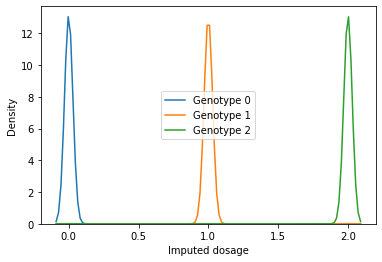

In [3]:
# load sanger (and cache) imputed data
sanger_feather = Path("/gpfs/commons/home/daknowles/pooledRBPs/genotypes/sanger.feather")
if sanger_feather.is_file(): 
    sanger = pd.read_feather(sanger_feather)
    del sanger["index"]
else: # this is pretty slow to read, so cache to feather
    sanger = io_utils.loadGenotypes(
        "/gpfs/commons/home/daknowles/pooledRBPs/genotypes/sanger.vcf.gz", 
        maxlines = None, 
        posterior = True,
        posterior_index = 2,
        print_every = 10000
    ) 
    sanger.reset_index().to_feather(sanger_feather)

cirm_lines = sanger.columns[5:16]
sanger_merge = geno.rename(columns = {"variantID" : "SNP"}).merge(sanger, on = ["SNP","refAllele","altAllele"], suffixes = ("_geno","_imp"))
geno_geno = sanger_merge.loc[:,cirm_lines.astype(str) + "_geno"].to_numpy()
geno_imp = sanger_merge.loc[:,cirm_lines.astype(str) + "_imp"].to_numpy()

### check imputation looks sensible on genotyped variants 
sns.kdeplot(geno_imp[geno_geno==0.], bw = 0.03, label = "Genotype 0")
sns.kdeplot(geno_imp[geno_geno==.5], bw = 0.03, label = "Genotype 1")
sns.kdeplot(geno_imp[geno_geno==1.], bw = 0.03, label = "Genotype 2")
plt.xlabel("Imputed dosage")
plt.ylabel("Density")
plt.legend()
plt.show() # nice! 